### Read data

**Import libraries**

In [44]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.model_selection import cross_val_score

In [45]:
df = pd.read_csv("assignment_rev2.csv.xls")

In [46]:
df.head(5)

,id,ranking_score,agent_id,geography_name,sq_meters,price,year_of_construction,floor,subtype,rooms,...,neoclassic,double_glass,for_commercial_use,fireplace,elevator,satellite,solar_heater,attic,pool,playroom
0,42911697,47.0,14680.0,northern sub,567,200000,2005,1,apartment,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,43018583,134.7,15502.0,northern sub,642,550000,1992,ground-floor,detached,5,...,False,True,False,True,True,False,False,True,False,True
2,39670968,71.0,9807.0,northern sub,320,500000,2009,ground-floor,detached,2,...,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN
3,39740833,122.0,14682.0,northern sub,95,230000,2007,1,apartment,3,...,False,True,False,True,True,False,False,False,False,False
4,39742998,126.7,14682.0,northern sub,195,370000,2007,ground-floor,maisonette,4,...,False,True,False,True,True,False,False,False,False,True


We have in total 15447 data points

### Clean data

**Replace/Remove NaN**

In [47]:
df.isnull().sum()

id                             0
ranking_score                  0
agent_id                     104
geography_name                 0
sq_meters                      0
price                          0
year_of_construction           0
floor                        732
subtype                        0
rooms                          0
no_of_bathrooms                0
energy_class               13340
renovation_year            13380
no_of_wc                       0
ad_type                        0
living_rooms                   0
kitchens                       0
balcony_area                   0
lux_home                    4238
new_development             3606
garage                      1630
furnished                   4169
preserved                   5433
investment                  4964
unfinished                  5420
equipped                   15447
heating_under_floor         4677
renovated                   4329
requires_renovation         4882
airy                        3518
bright    

In [48]:
# remove NAs from agent_id as this is information we want to have and only ~0.7% of the data will be dropped
df.dropna(axis = 0, subset = ["agent_id"], inplace = True)

# remove NAs from floor as this is information we want to have and only ~5% of the data will be dropped
df.dropna(axis = 0, subset = ["floor"], inplace = True)

# column equipped contains only NA values - so drop the entire column from df
df.drop(columns=['equipped'], inplace = True)

# column energy_class contains ~95% NA values - so drop the entire column from df
df.drop(columns=['energy_class'], inplace = True)

# ASSUMPTION: for values in binary columns, the NA is in reality a 0 - ie there is not such item in the property
# we will do this when cleaning the data types (look below)

# NA in renovation_year means that the property has not been renovated and this is important information so we will not change it
# however since we only have values for 14% of the data points, then will do some feature engineering later on - i.e. binary value: renovated 1/0

In total have dropped only ~5% of the data. Now we have 14614 data points.

**Clean data types**

In [49]:
# change agent_id and renovation_year from float to int
df['agent_id'] = df['agent_id'].astype('Int64')
df['renovation_year'] = df['renovation_year'].astype('Int64')

# change all object/boolean to int/binary
# ASSUMPTION: for values in binary columns, the NA is in reality a 0 - ie there is not such item in the property
for a in df.select_dtypes(include=object):
    try:
        df[a].replace({False: 0, True: 1}, inplace=True)
        df[a] = df[a].astype('Int64')
        df[a] = df[a].fillna(0)
    except:
        pass

**Feature Engineering**

In [50]:
df.renovation_year.unique()

<IntegerArray>
[<NA>, 2000, 2014, 1987, 2005, 2009, 1995, 2007, 2015, 2012, 2016, 2004, 2018,
 2013, 2008, 1980, 2010, 2017, 1996, 2011, 2001, 1977, 2002, 2006, 1988, 1999,
 2019, 1990, 2003, 1997, 1998, 1994, 1991, 1986, 1992, 1989, 1967, 1981, 1970,
 1960, 1975, 1976, 1973, 1985, 1982, 1950, 1983, 1993]
Length: 48, dtype: Int64

In [51]:
df['renovated'] = np.where(df['renovation_year'].isna()==True, 0, 1)
df.drop(columns=['renovation_year'], inplace=True)

**Deeper look into the highlighted variables mentioned in assignment**

/var/folders/sf/x69fjdzx605fn55k8l21h2yc0000gn/T/ipykernel_9656/1585622511.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


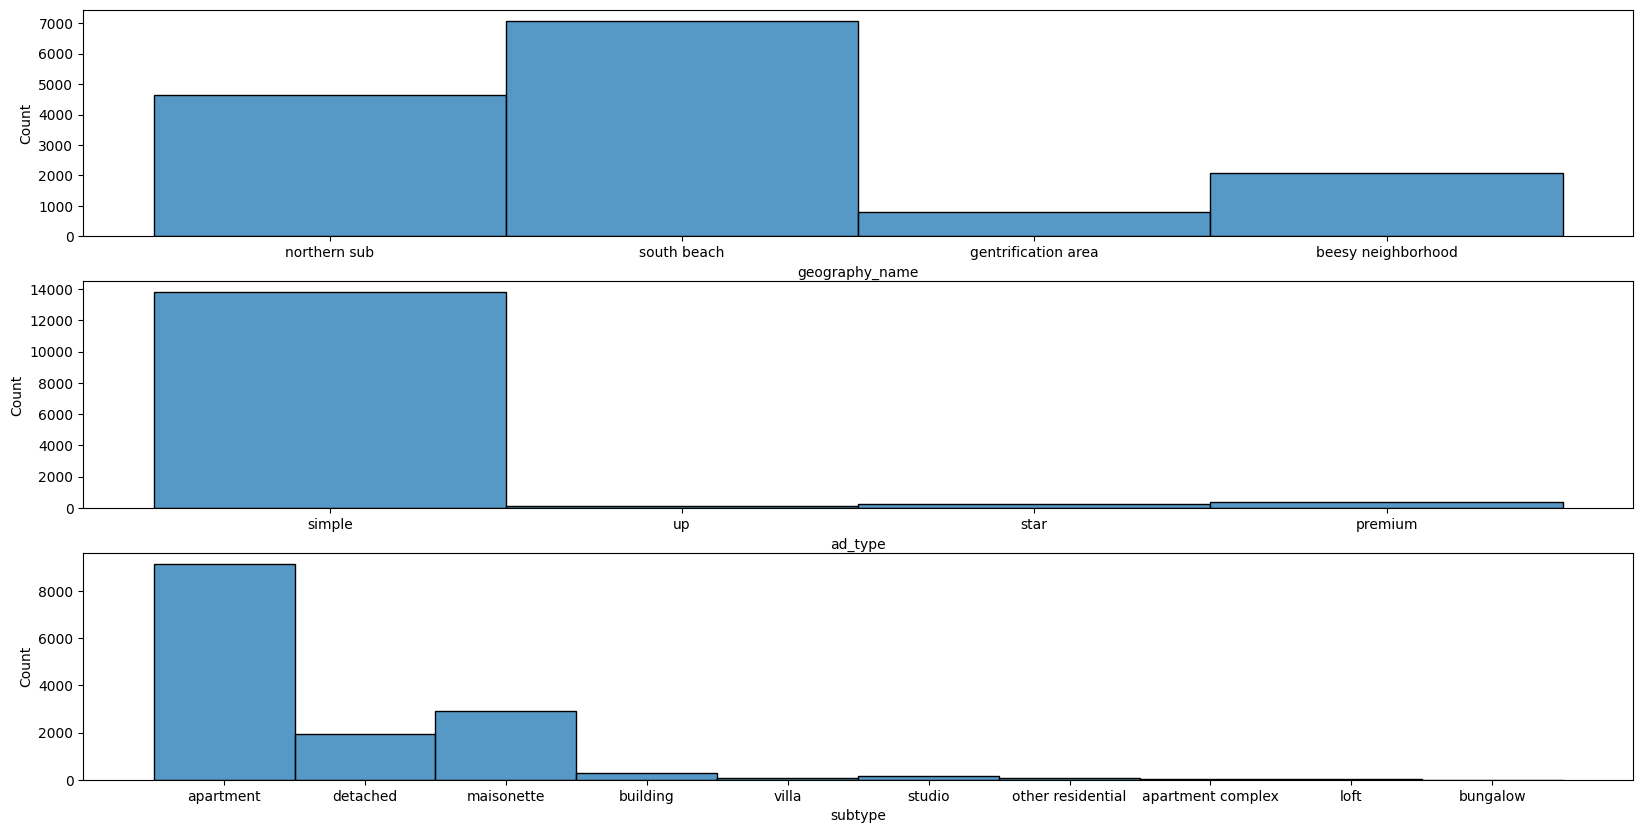

In [52]:
# Plot histograms for the categorical features

fig, ax = plt.subplots(3,1, figsize=(20,10))
sns.histplot(df['geography_name'], ax = ax[0])
sns.histplot(df['ad_type'], ax = ax[1])
sns.histplot(df['subtype'], ax = ax[2])
fig.show()

/var/folders/sf/x69fjdzx605fn55k8l21h2yc0000gn/T/ipykernel_9656/2049019640.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


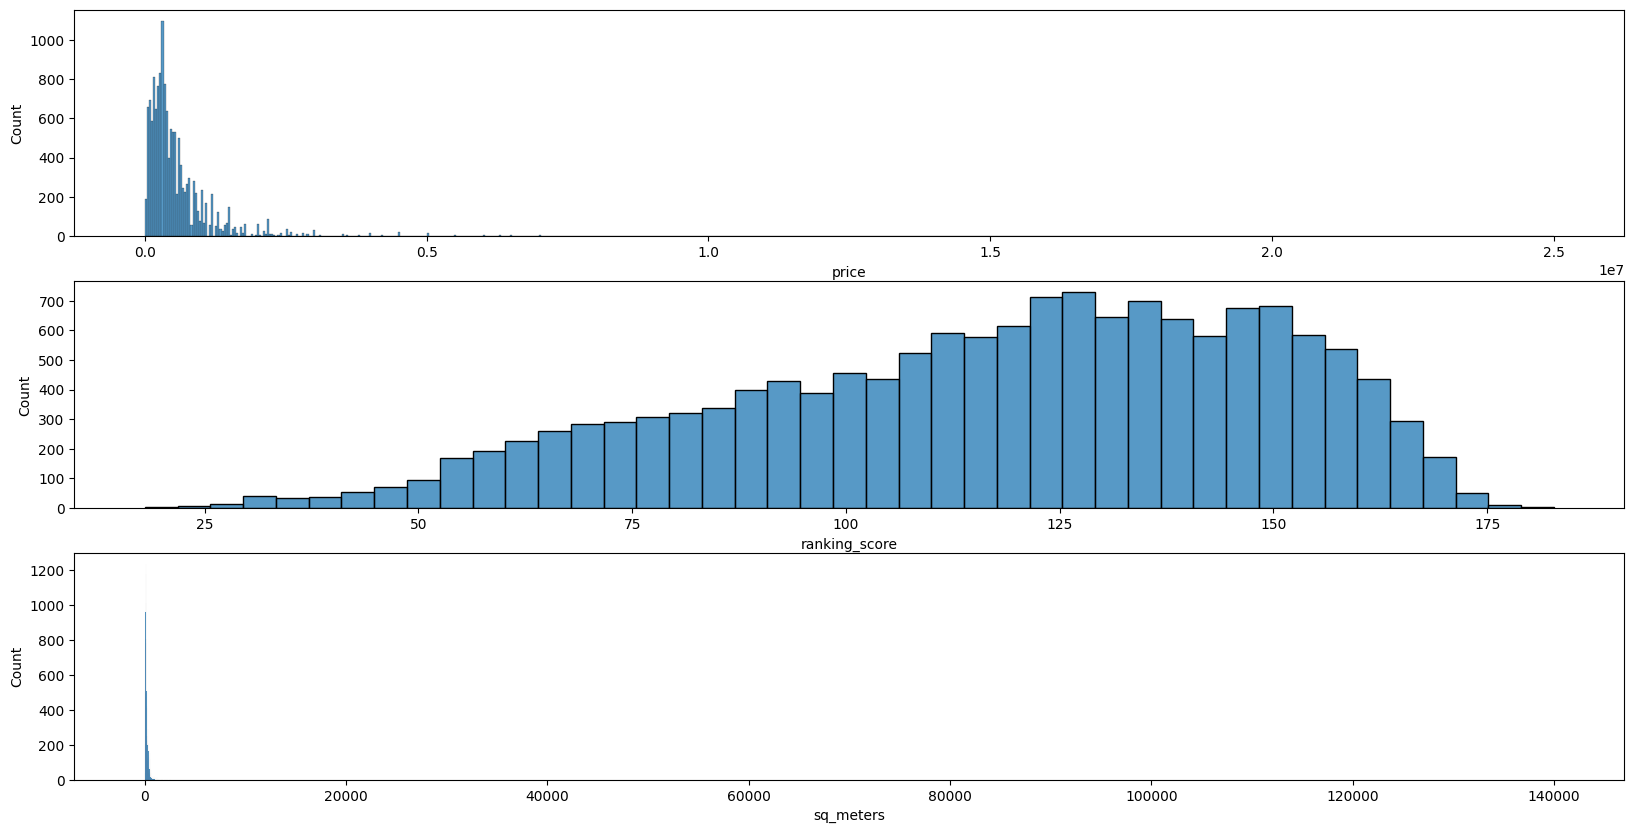

In [53]:
# Plot histograms for the numerical features

fig, ax = plt.subplots(3,1, figsize=(20,10))
sns.histplot(df['price'], ax = ax[0])
sns.histplot(df['ranking_score'], ax = ax[1])
sns.histplot(df['sq_meters'], ax = ax[2])
fig.show()

From the above histograms, we can clearly see that there are outliers in price and sq_meters which need to be treated

/var/folders/sf/x69fjdzx605fn55k8l21h2yc0000gn/T/ipykernel_9656/1251574918.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


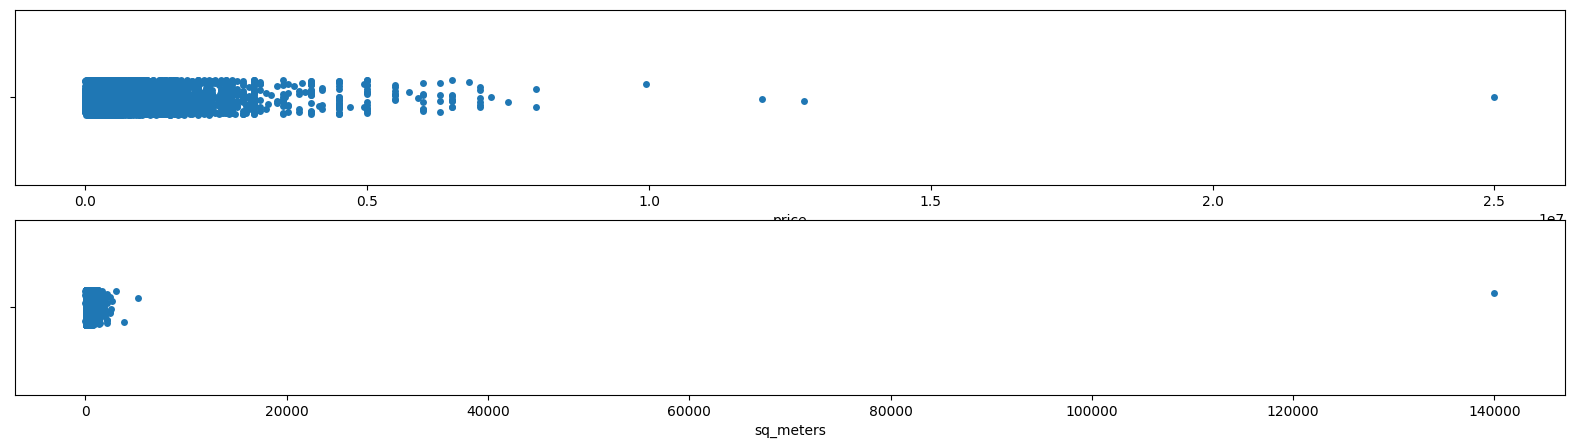

In [54]:
# plot for every numeric variable a stripplot to identify outliers

fig, ax = plt.subplots(2,1, figsize=(20,5))
sns.stripplot(df['price'], ax = ax[0], orient = 'h')
sns.stripplot(df['sq_meters'], ax = ax[1], orient = 'h')
fig.show()

### Remove outliers

In [55]:
# remove outliers based on z-score

df = df[(np.abs(stats.zscore(df[['price', 'sq_meters']])) < 3).all(axis=1)]
df.reset_index(drop = True, inplace = True)
df

,id,ranking_score,agent_id,geography_name,sq_meters,price,year_of_construction,floor,subtype,rooms,...,neoclassic,double_glass,for_commercial_use,fireplace,elevator,satellite,solar_heater,attic,pool,playroom
0,42911697,47.0,14680,northern sub,567,200000,2005,1,apartment,4,...,0,0,0,0,0,0,0,0,0,0
1,43018583,134.7,15502,northern sub,642,550000,1992,ground-floor,detached,5,...,0,1,0,1,1,0,0,1,0,1
2,39670968,71.0,9807,northern sub,320,500000,2009,ground-floor,detached,2,...,0,0,0,1,0,0,0,0,0,0
3,39740833,122.0,14682,northern sub,95,230000,2007,1,apartment,3,...,0,1,0,1,1,0,0,0,0,0
4,39742998,126.7,14682,northern sub,195,370000,2007,ground-floor,maisonette,4,...,0,1,0,1,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14387,43079210,101.0,19009,beesy neighborhood,80,75000,1960,3,apartment,2,...,0,0,0,0,0,0,0,0,0,0
14388,43079212,103.5,19009,beesy neighborhood,69,70000,1975,2,apartment,2,...,0,0,0,0,0,0,0,0,0,0
14389,43079508,118.1,6976,beesy neighborhood,75,120000,1974,3,apartment,1,...,0,1,0,0,0,0,0,0,0,0
14390,40498665,78.7,7354,beesy neighborhood,800,600000,1930,ground-floor,building,1,...,0,0,0,0,0,0,0,0,0,0


/var/folders/sf/x69fjdzx605fn55k8l21h2yc0000gn/T/ipykernel_9656/2049019640.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


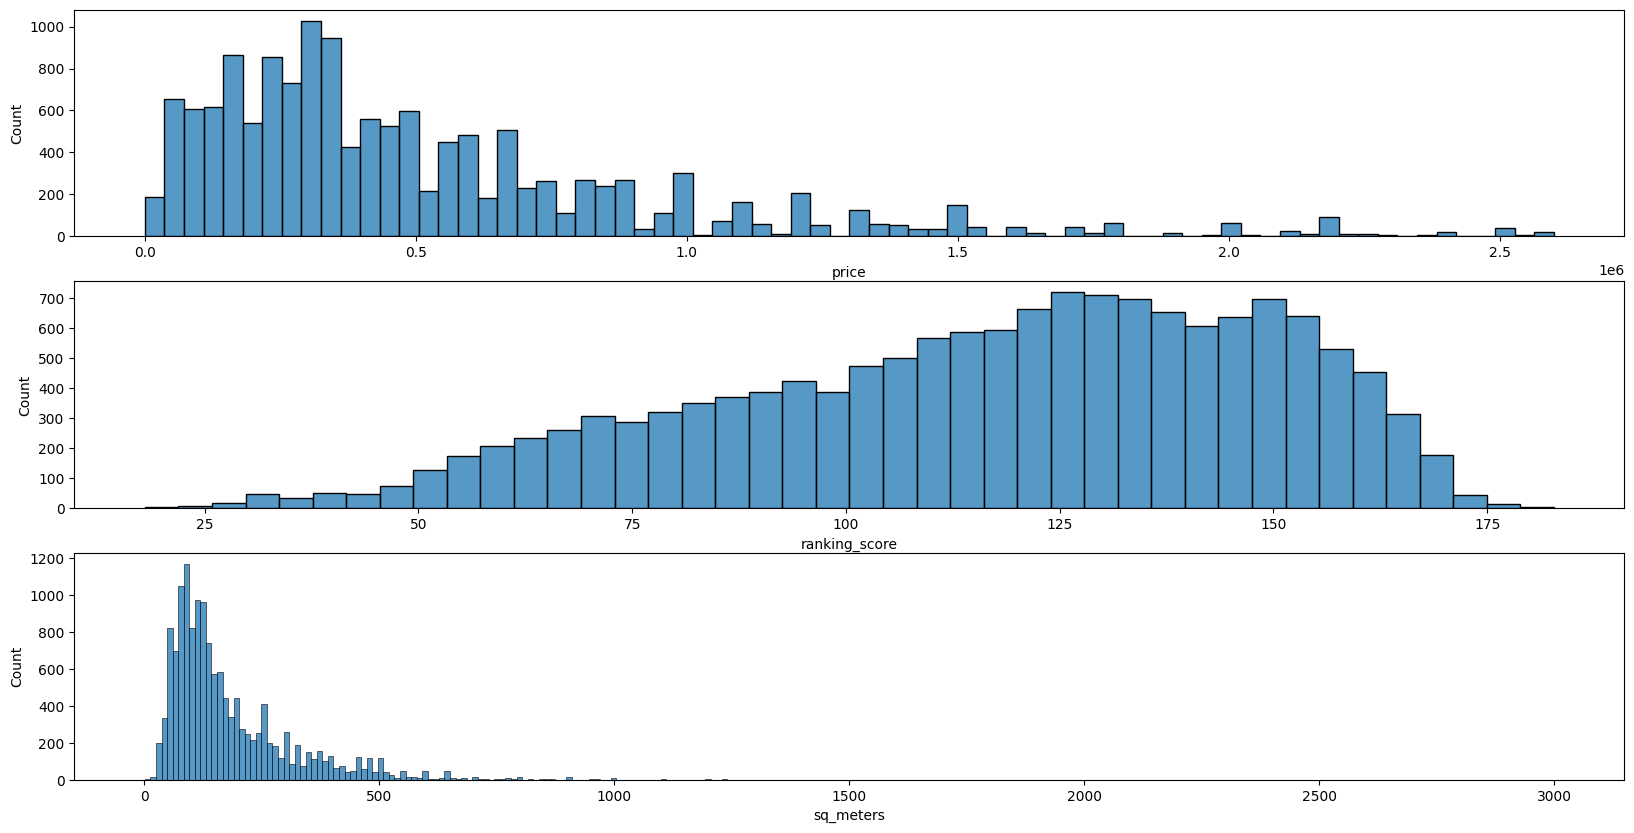

In [56]:
# Plot histograms for the numerical features

fig, ax = plt.subplots(3,1, figsize=(20,10))
sns.histplot(df['price'], ax = ax[0])
sns.histplot(df['ranking_score'], ax = ax[1])
sns.histplot(df['sq_meters'], ax = ax[2])
fig.show()

/var/folders/sf/x69fjdzx605fn55k8l21h2yc0000gn/T/ipykernel_9656/1251574918.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


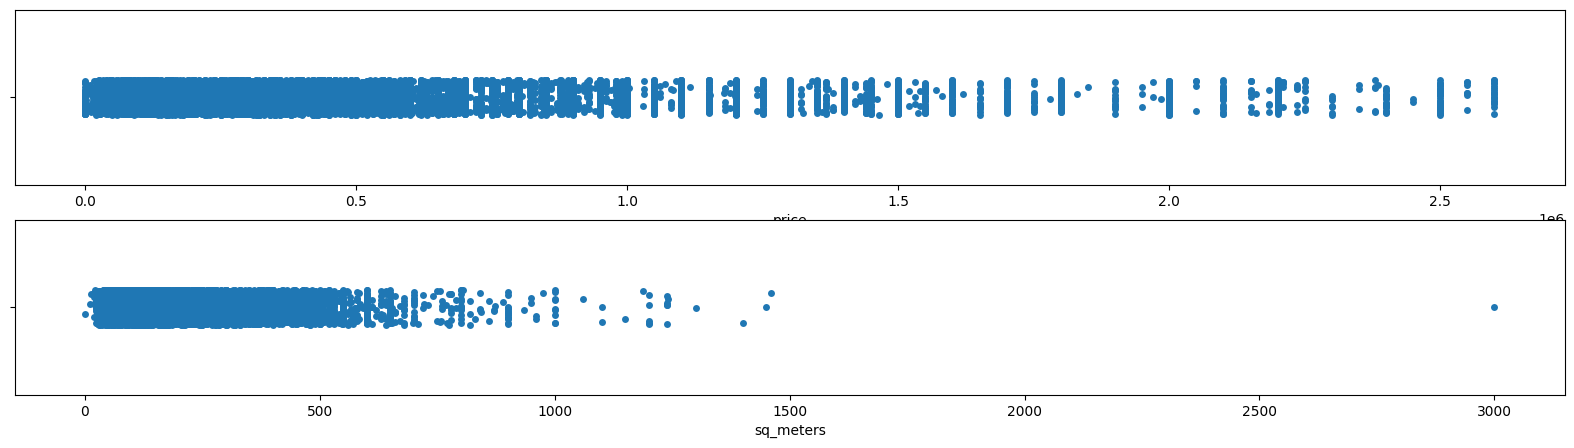

In [57]:
# plot for every numeric variable a stripplot to identify outliers

fig, ax = plt.subplots(2,1, figsize=(20,5))
sns.stripplot(df['price'], ax = ax[0], orient = 'h')
sns.stripplot(df['sq_meters'], ax = ax[1], orient = 'h')
fig.show()

### Part 1

**Calculate the mean, median, and standard deviation of property prices**

In [58]:
# by subtype
subtype_stats = df.groupby('subtype')['price'].agg(['mean', 'median', 'std']).round(2)

# by area
area_stats = df.groupby('geography_name')['price'].agg(['mean', 'median', 'std']).round(2)

# by area and subtype
stats = df.groupby(['subtype', 'geography_name'])['price'].agg(['mean', 'median', 'std']).round(2)


print("Statistics by subtype:\n", subtype_stats)
print("\nStatistics by area:\n", area_stats)
print("\nStatistics by subtype and area:\n", stats)


Statistics by subtype:
                          mean     median        std
subtype                                            
apartment           352358.03   290000.0  292769.84
apartment complex   996447.39   975000.0  556733.36
building            833295.16   665000.0  491431.14
bungalow             66500.00    66500.0    2121.32
detached            947534.65   850000.0  546956.73
loft                553272.73   369000.0  357646.78
maisonette          749111.15   620000.0  461780.81
other residential   651321.88   510000.0  485695.12
studio               57725.90    50000.0   42350.08
villa              1351260.87  1165000.0  571436.61

Statistics by area:
                           mean    median        std
geography_name                                     
beesy neighborhood   132187.87   95000.0  136837.16
gentrification area  242363.41  190000.0  234019.94
northern sub         668658.62  550000.0  437312.43
south beach          567787.88  400000.0  454765.10

Statistics by sub

**Plot property prices against subtypes and area**

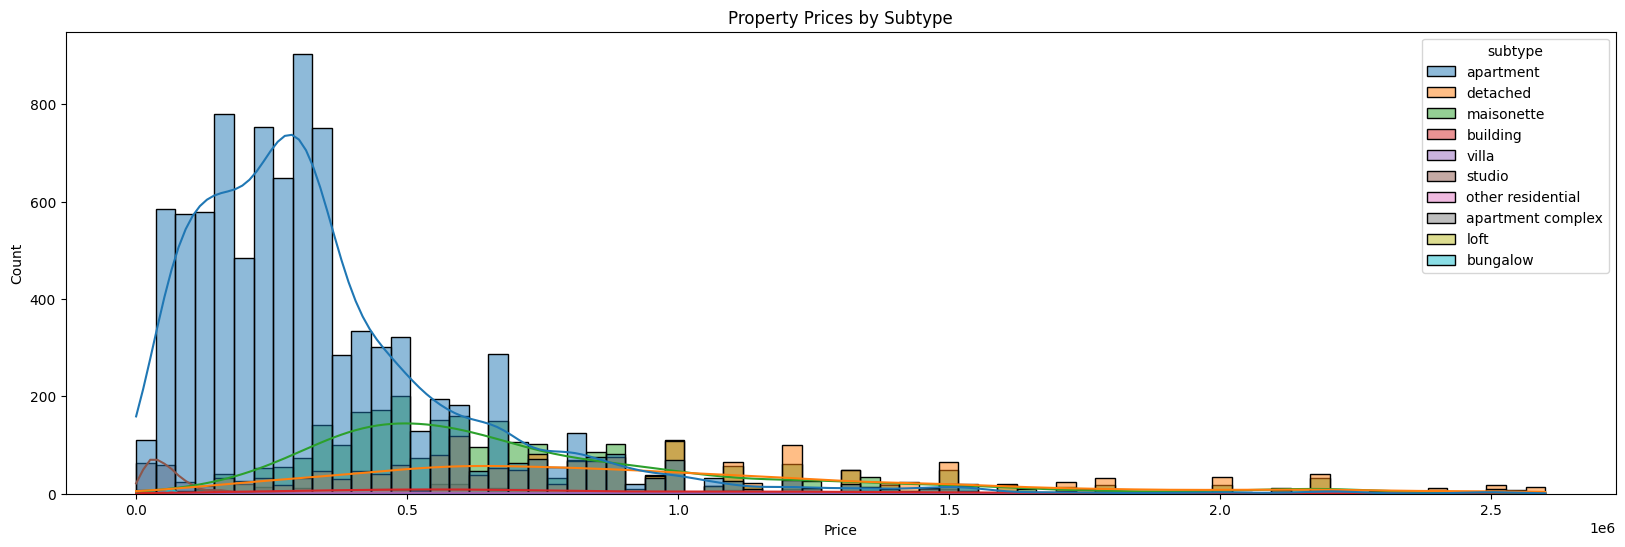

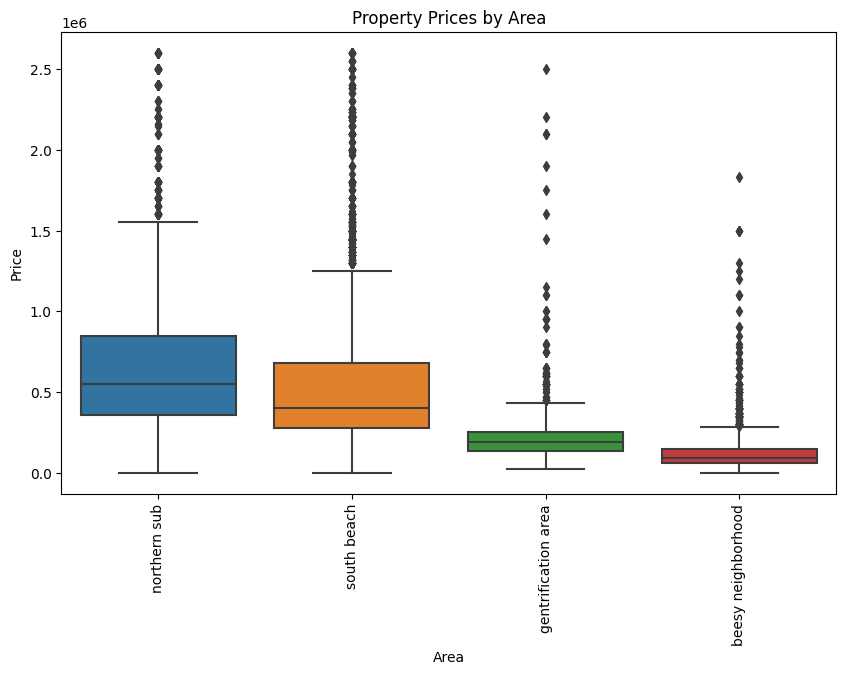

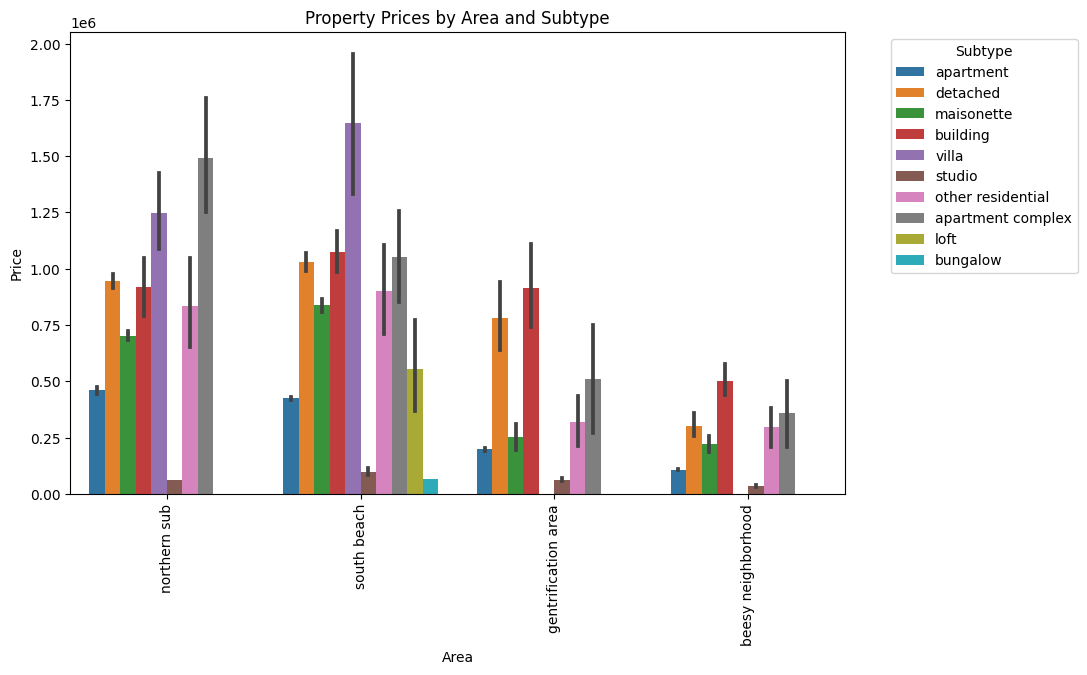

In [59]:
# histogram of property prices by subtype
plt.figure(figsize=(20,6))
sns.histplot(data=df, x='price', hue='subtype', kde=True)
plt.xlabel('Price')
plt.ylabel('Count')
plt.title('Property Prices by Subtype')
plt.show()

# boxplot of property prices by area
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='geography_name', y='price')
plt.xlabel('Area')
plt.ylabel('Price')
plt.title('Property Prices by Area')
plt.xticks(rotation=90)
plt.show()

# grouped barchart of property prices by area and subtype
plt.figure(figsize=(10,6))
sns.barplot(data=df, x='geography_name', y='price', hue='subtype')
plt.xlabel('Area')
plt.ylabel('Price')
plt.title('Property Prices by Area and Subtype')
plt.xticks(rotation=90)
plt.legend(title='Subtype', bbox_to_anchor=(1.05, 1))
plt.show()


**Insights generated**

There are several insights that can be drawn from the statistics presented:

- The most expensive property type on average is villa, with a mean price of 1351260.87 and a median of 1165000.0, followed by detached houses with a mean of 947534.65 and a median of 850000.0.
- The cheapest type of property on average is a studio with a mean price of 57725.90 and a median of 50000.0.
- The subtype with the highest standard deviation in price is the apartment complex, which has a mean price of 996447.39 and a standard deviation of 556733.36.
- The most expensive geographic area on average is the south beach, with a mean price of 567787.88 and a median of 400000.0. The northern sub follows closely, with a mean price of 668658.62 and a median of 550000.0.
- The cheapest geographic area on average is beesy neighborhood, with a mean price of 132187.87 and a median of 95000.0.

Looking at the statistics by subtype and area:

- The most expensive subtype in the most expensive area (South Beach) is villa, with a mean price of 1646666.67 and a median of 1575000.0. In the cheapest area (Beesy Neighborhood), the most expensive subtype is building, with a mean price of 502372.09 and a median of 445000.0.

- In the "apartment" subtype, we can see that the average price in the "beesy neighborhood" area is much lower than the average price in the other three areas, with a mean price of 107,432.45 compared to 459,241.94 in the "northern sub" area, 423,937.50 in "south beach" and 197,956.52 in the "gentrification area". Similarly, we can see that the highest average price for apartments is in the "northern sub" area, with a mean price of 668,658.62, and the lowest average price is in the "beesy neighborhood" area, with a mean price of 132,187.87.

- We can observe similar trends for other subtypes as well. For instance, the "apartment complex" subtype has the highest average prices in the "northern sub" area and the lowest average prices in the "beesy neighborhood" area. On the other hand, "villa" properties have the highest average prices in the "south beach" area, with a mean price of 1,646,666.67, and the highest standard deviation among all the subtypes and areas.

### Part 2

To calculate the competitiveness metrics for each area, we can consider the following factors:

1. Number of listings: The more listings there are in an area, the more competition there is for each listing to rank high.
2. Ranking score distribution: If the ranking scores for listings in an area are highly concentrated around a narrow range, it indicates that it is hard for a listing to stand out and rank high.
3. Listing quality: If there are many high-quality listings in an area, it would be harder for a simple listing to rank high.
4. Price: If the prices for listings in an area are highly concentrated around a narrow range, it indicates that it is hard for a listing to stand out and rank high based on price alone.

**Number of listings**

To calculate the competitiveness metrics based on the number of listings for each area, we can follow these steps:

1. Group the listings by their geography name to get the number of listings in each area.
2. Calculate the maximum number of listings for any area.
3. Calculate the competitiveness metric for each area as the ratio of the number of listings in that area to the maximum number of listings.

The competitiveness metric will be a value between 0 and 1, where 1 represents the most competitive area (i.e., the area with the highest number of listings).

In [60]:
# Group the listings by geography name and count the number of listings in each area
area_counts = df.groupby('geography_name')['id'].count().reset_index()
area_counts.rename(columns={'id': 'listing_count'}, inplace=True)

# Calculate the maximum number of listings for any area
max_listings = area_counts['listing_count'].max()

# Calculate the competitiveness metric for each area
area_counts['competitiveness'] = area_counts['listing_count'] / max_listings

# Sort the areas by competitiveness score
area_counts = area_counts.sort_values('competitiveness', ascending=False)

print(area_counts)


        geography_name  listing_count  competitiveness
3          south beach           7027         1.000000
2         northern sub           4479         0.637399
0   beesy neighborhood           2077         0.295574
1  gentrification area            809         0.115127


In [61]:
# Group the listings by geography name and count the number of listings in each area
area_counts = df.groupby('geography_name')['id'].count().reset_index()
area_counts.rename(columns={'id': 'listing_count'}, inplace=True)

# Calculate the maximum number of listings for any area
max_listings = area_counts['listing_count'].max()

# Calculate the average ranking score for each area
area_avg_rank = df.groupby('geography_name')['ranking_score'].mean().reset_index()
area_avg_rank.rename(columns={"ranking_score": "mean"}, inplace=True)

# Merge the two dataframes
area_counts = pd.merge(area_avg_rank, area_counts, on='geography_name')

# Calculate the competitiveness metric for each area
area_counts['competitiveness'] = area_counts['listing_count'] / area_counts['mean']

# Sort the areas by competitiveness score
area_counts = area_counts.sort_values('competitiveness', ascending=False)

print(area_counts)


        geography_name        mean  listing_count  competitiveness
3          south beach  118.757478           7027        59.171011
2         northern sub  117.877517           4479        37.997068
0   beesy neighborhood  112.354694           2077        18.486099
1  gentrification area  119.791965            809         6.753374


**Ranking score distribution**

In [62]:
# Calculate the average ranking score for each area
area_avg_rank = df.groupby('geography_name')['ranking_score'].mean().reset_index()
area_avg_rank.rename(columns={"ranking_score": "mean"}, inplace=True)

# Calculate the standard deviation of ranking scores for each area
area_std_rank = df.groupby('geography_name')['ranking_score'].std().reset_index()
area_std_rank.rename(columns={"ranking_score": "std"}, inplace=True)

# Merge the two dataframes
area_ranking = pd.merge(area_avg_rank, area_std_rank, on='geography_name')

# Calculate the competitiveness score for each area
area_ranking['competitiveness'] = area_ranking['std'] / area_ranking['mean']

# Sort the areas by competitiveness score
area_ranking = area_ranking.sort_values('competitiveness', ascending=False)

print(area_ranking)


        geography_name        mean        std  competitiveness
0   beesy neighborhood  112.354694  33.345401         0.296787
3          south beach  118.757478  31.672908         0.266702
2         northern sub  117.877517  30.337549         0.257365
1  gentrification area  119.791965  30.735014         0.256570


**Listing quality**

To calculate the competitiveness metrics for each area based on the listing quality, we can use the following steps:

1. Group the listings by geography_name.
2. Calculate the average ranking_score for each area.
3. Calculate the standard deviation of the ranking_score for each area.
4. Calculate the coefficient of variation (CV) for each area, which is the ratio of the standard deviation to the mean.
5. Sort the areas by their CV in ascending order to identify the most competitive areas.

The CV column represents the competitiveness metric for each area, with lower values indicating higher competitiveness.

In [63]:
# Group the listings by geography_name and calculate the average ranking_score and its standard deviation for each area
area_metrics_df = df.groupby('geography_name')['ranking_score'].agg(['mean', 'std']).reset_index()

# Calculate the coefficient of variation (CV) for each area
area_metrics_df['CV'] = area_metrics_df['std'] / area_metrics_df['mean']

# Sort the areas by their CV in ascending order to identify the most competitive areas
area_metrics_df = area_metrics_df.sort_values('CV')

print(area_metrics_df)


        geography_name        mean        std        CV
1  gentrification area  119.791965  30.735014  0.256570
2         northern sub  117.877517  30.337549  0.257365
3          south beach  118.757478  31.672908  0.266702
0   beesy neighborhood  112.354694  33.345401  0.296787


**Price**

To calculate the competitiveness metrics for each area based on the price, we can use the following approach:

1. Group the listings by the geography_name column to get the total number of listings and the average price for each area.
2. Sort the areas based on the average price in descending order to get the most expensive areas first.
3. Calculate the percentage difference between the average price in each area and the overall average price for all areas.
4. Normalize the percentage difference values to be between 0 and 1, with 0 being the least competitive area and 1 being the most competitive area.

This code will calculate the competitiveness metrics based on price and print out the number of listings, the average price, and the normalized percentage difference for each area. The results can be used to determine the level of discount to be given to agents in each area based on the competitiveness of the market.

In [64]:
# Calculate competitiveness metrics based on price
area_price = df.groupby('geography_name')['price'].agg(['count', 'mean'])
area_price['price_diff'] = (area_price['mean'] - df['price'].mean()) / df['price'].mean()
area_price['price_diff_norm'] = (area_price['price_diff'] - area_price['price_diff'].min()) / (area_price['price_diff'].max() - area_price['price_diff'].min())
area_price = area_price.sort_values(by='mean', ascending=False)

# Print the results
print(area_price[['count', 'mean', 'price_diff_norm']])


                     count           mean  price_diff_norm
geography_name                                            
northern sub          4479  668658.622014         1.000000
south beach           7027  567787.878753         0.811973
gentrification area    809  242363.411619         0.205371
beesy neighborhood    2077  132187.867116         0.000000


**Plots**

Bar chart showing the average ranking score for each area:

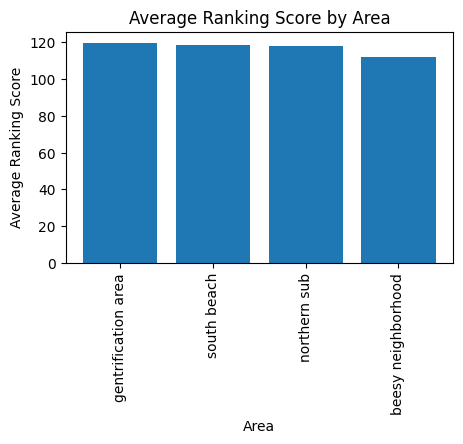

In [65]:
avg_ranking_scores = df.groupby('geography_name')['ranking_score'].mean().sort_values(ascending=False)

plt.figure(figsize=(5,3))
plt.bar(avg_ranking_scores.index, avg_ranking_scores.values)
plt.xticks(rotation=90)
plt.title('Average Ranking Score by Area')
plt.xlabel('Area')
plt.ylabel('Average Ranking Score')
plt.show()


Bar chart showing the number of listings in each area:

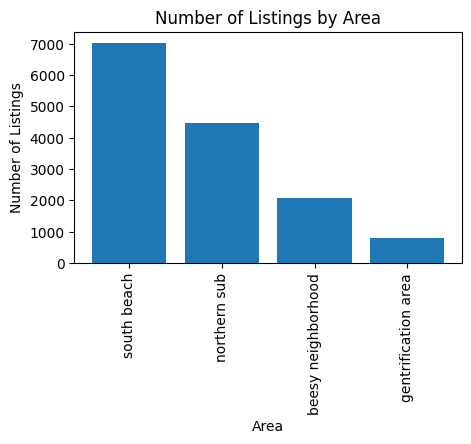

In [66]:
num_listings = df['geography_name'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(5,3))
plt.bar(num_listings.index, num_listings.values)
plt.xticks(rotation=90)
plt.title('Number of Listings by Area')
plt.xlabel('Area')
plt.ylabel('Number of Listings')
plt.show()


Scatter plot showing the relationship between average price and average ranking score for each area:

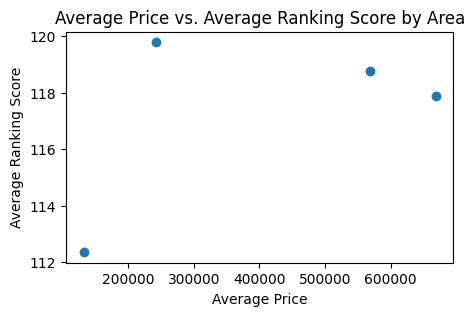

In [67]:
avg_price = df.groupby('geography_name')['price'].mean()
avg_ranking_scores = df.groupby('geography_name')['ranking_score'].mean()

plt.figure(figsize=(5,3))
plt.scatter(avg_price, avg_ranking_scores)
plt.title('Average Price vs. Average Ranking Score by Area')
plt.xlabel('Average Price')
plt.ylabel('Average Ranking Score')
plt.show()

Scatter plot showing the relationship between number of listings and average ranking score for each area:

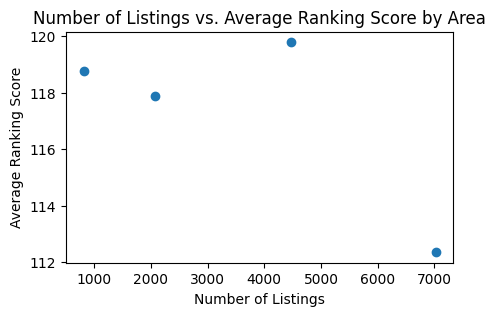

In [68]:
num_listings = df['geography_name'].value_counts()
avg_ranking_scores = df.groupby('geography_name')['ranking_score'].mean()

plt.figure(figsize=(5,3))
plt.scatter(num_listings, avg_ranking_scores)
plt.title('Number of Listings vs. Average Ranking Score by Area')
plt.xlabel('Number of Listings')
plt.ylabel('Average Ranking Score')
plt.show()


To decide the level of discount to be given to agents in each area based on the competitiveness metrics for each area based on the listing quality, we should consider the following:

A lower value of the CV column indicates higher competitiveness, which means that it is harder for a listing to rank high in the search results of that area just by having a high ranking score.
The level of discount should be proportional to the level of competitiveness. The higher the competitiveness, the higher the discount should be.
Based on the results of the competitiveness metrics, the beesy neighborhood has the highest CV value of 0.296787, indicating the highest level of competitiveness. Therefore, agents in the beesy neighborhood should be given the highest discount.

On the other hand, the northern sub and south beach have lower CV values of 0.257365 and 0.266702, respectively, indicating lower levels of competitiveness compared to beesy neighborhood. Therefore, agents in these areas should be given lower discounts than beesy neighborhood.

Finally, the gentrification area has a CV value of 0.256570, which is slightly lower than northern sub and south beach, indicating a slightly lower level of competitiveness. Therefore, agents in this area should be given a discount lower than beesy neighborhood but higher than northern sub and south beach.

### Part 3

**Correlation**

<function matplotlib.pyplot.show(close=None, block=None)>

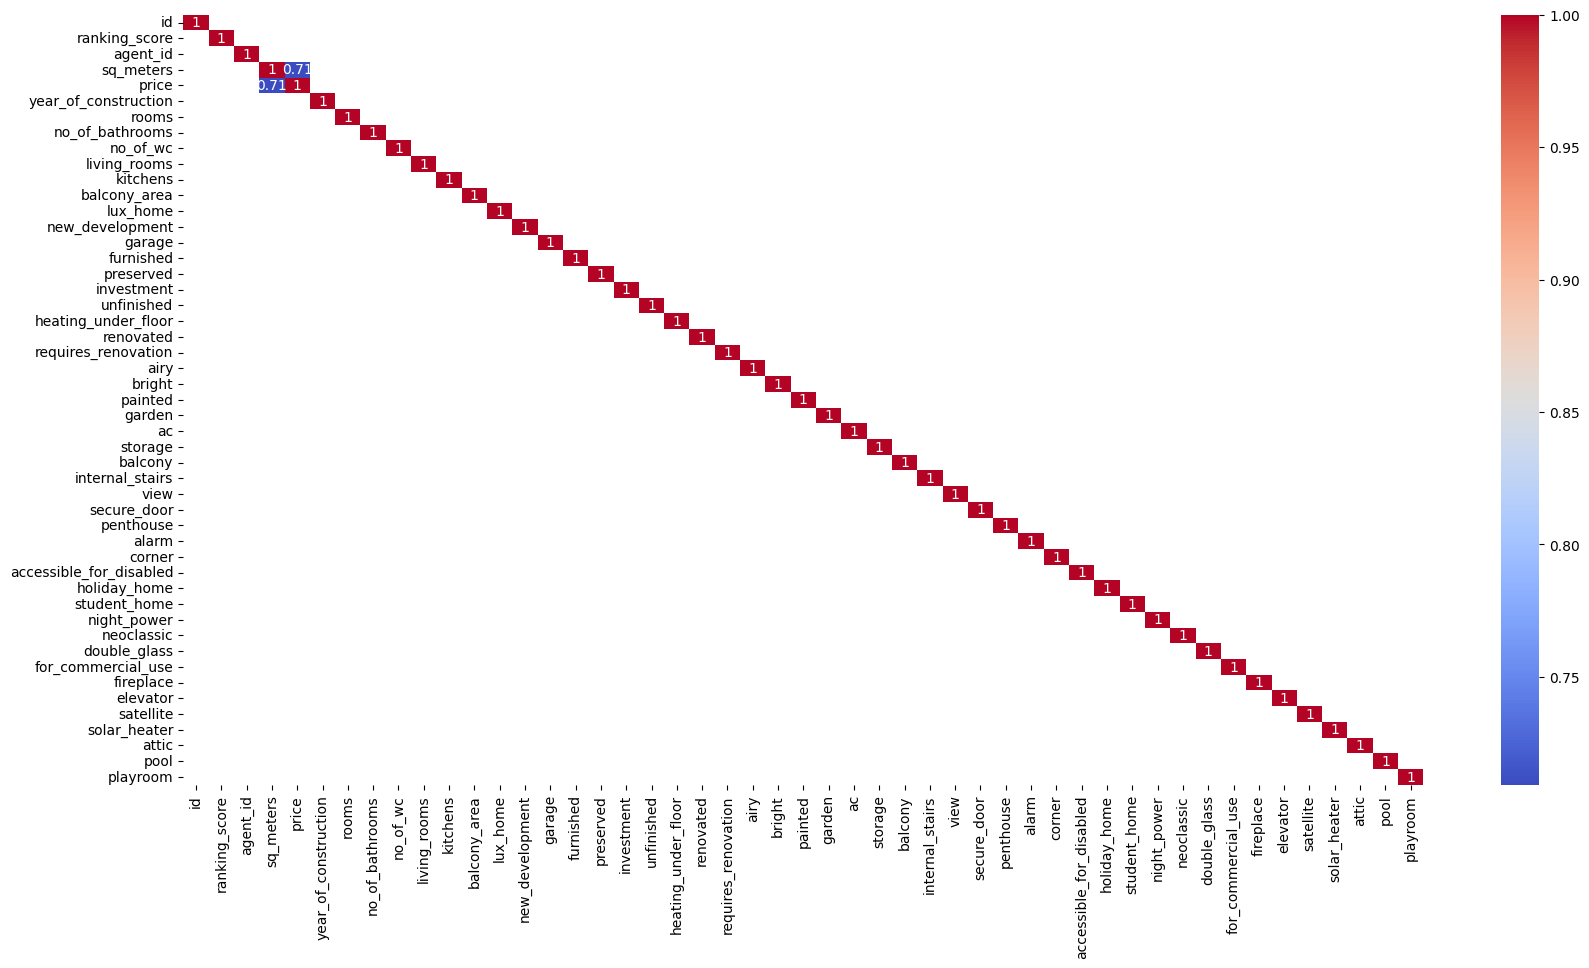

In [69]:
corr_matrix = df.corr()
plt.figure(figsize=(20,10))
sns.heatmap(corr_matrix[(corr_matrix >= 0.7) | (corr_matrix <= -0.7)], cmap='coolwarm', annot=True)
plt.show

**Models**

In [70]:
# train-test split
X = df.drop('price', axis=1)
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# define categorical and numerical columns
categorical_cols = ['geography_name', 'floor', 'subtype', 'ad_type']
numeric_cols = ['ranking_score', 'sq_meters', 'year_of_construction', 'rooms', 'no_of_bathrooms', 'no_of_wc', 'living_rooms', 'kitchens', 'balcony_area']

# preprocessing steps for the categorical and numerical columns
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
numeric_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_cols),
        ('num', numeric_transformer, numeric_cols)
    ])

In [71]:
# linear regression model
pipeline_lr = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

# random forest model
pipeline_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor())
])

# XGBoost model
pipeline_xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('model', xgb.XGBRegressor())
])

# evaluate the performance of the linear regression model using cross-validation
scores_lr = cross_val_score(pipeline_lr, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
mse_lr = -1 * scores_lr.mean()
rmse_lr = np.sqrt(mse_lr)

# evaluate the performance of the Random Forest model using cross-validation
scores_rf = cross_val_score(pipeline_rf, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
mse_rf = -1 * scores_rf.mean()
rmse_rf = np.sqrt(mse_rf)

# evaluate the performance of the XGBoost model using cross-validation
scores_xgb = cross_val_score(pipeline_xgb, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
mse_xgb = -1 * scores_xgb.mean()
rmse_xgb = np.sqrt(mse_xgb)

# performance metrics
print("Linear Regression RMSE: {:.2f}".format(rmse_lr))
print("Random Forest RMSE: {:.2f}".format(rmse_rf))
print("XGBoost RMSE: {:.2f}".format(rmse_xgb))

# comparison
if rmse_lr < rmse_rf and rmse_lr < rmse_xgb:
    print("\nLinear Regression is the better model")
elif rmse_rf < rmse_lr and rmse_rf < rmse_xgb:
    print("\nRandom Forest is the better model")
else:
    print("\nXGBoost is the better model")


Linear Regression RMSE: 3797542726053819.50
Random Forest RMSE: 206187.57
XGBoost RMSE: 216936.27

Random Forest is the better model


In [72]:
# fit the pipeline to the training data
pipeline_rf.fit(X_train, y_train)

# get feature importances from the fitted model
feature_importances = pipeline_rf.named_steps['model'].feature_importances_

importances_descending = sorted(zip(feature_importances, X_train.columns), reverse=True)
for importance, feature in importances_descending:
    print(f"{feature}: {importance}")

# make predictions using the pipeline
y_pred = pipeline_rf.predict(X_test)


secure_door: 0.6509992682670258
penthouse: 0.10235029720178826
view: 0.044157191674465704
geography_name: 0.028725719451346495
id: 0.024923343652472178
alarm: 0.018928962832445374
corner: 0.01867189131134956
no_of_bathrooms: 0.01741662967396277
accessible_for_disabled: 0.011046086305423093
renovated: 0.010626478725301678
agent_id: 0.009555856839621221
airy: 0.008060294170108059
student_home: 0.0075923141983531926
holiday_home: 0.006852454461725511
night_power: 0.006825955010384357
subtype: 0.005953492294994653
preserved: 0.005788799604172266
new_development: 0.005620089373452237
no_of_wc: 0.002843923118417891
sq_meters: 0.0024286756747758102
unfinished: 0.001870693798428949
garage: 0.0009962068527776496
balcony: 0.0009916216200608044
garden: 0.0009851642182466304
ad_type: 0.0009653536326479351
lux_home: 0.0009359853308101231
storage: 0.0008934538636019118
ranking_score: 0.0006255666787321896
ac: 0.0005949387132224472
bright: 0.000522470483877824
furnished: 0.0004001556887765512
interna

In [73]:
# define categorical and numerical columns
categorical_cols = ['geography_name', 'floor', 'subtype', 'ad_type']
numeric_cols = ['ranking_score', 'sq_meters', 'year_of_construction', 'rooms', 'no_of_bathrooms', 'no_of_wc', 'living_rooms', 'kitchens', 'balcony_area']

# preprocessing steps for the categorical and numerical columns
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
numeric_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_cols),
        ('num', numeric_transformer, numeric_cols)
    ])

# pipeline with the preprocessor and a linear regression model
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

# fit the pipeline to the data
pipeline.fit(X_train, y_train)

# make predictions using the pipeline
y_pred = pipeline.predict(X_test)

In [74]:
# Get the feature names from the one-hot encoder
cat_feature_names = pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_cols)

# Combine the feature names from the one-hot encoder and the numeric columns
feature_names = list(cat_feature_names) + numeric_cols

# Get the coefficients of the linear regression model
coef = pipeline.named_steps['model'].coef_

# Create a DataFrame to display the feature names and their corresponding coefficients
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coef})
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()  # Add a column for absolute coefficient value
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

print(coef_df)


                               Feature   Coefficient  Abs_Coefficient
25                  subtype_maisonette  1.612199e+17     1.612199e+17
23                    subtype_detached  1.612199e+17     1.612199e+17
26           subtype_other residential  1.612199e+17     1.612199e+17
28                       subtype_villa  1.612199e+17     1.612199e+17
24                        subtype_loft  1.612199e+17     1.612199e+17
19                   subtype_apartment  1.612199e+17     1.612199e+17
27                      subtype_studio  1.612199e+17     1.612199e+17
20           subtype_apartment complex  1.612199e+17     1.612199e+17
21                    subtype_building  1.612199e+17     1.612199e+17
22                    subtype_bungalow  1.612199e+17     1.612199e+17
3           geography_name_south beach  1.172703e+17     1.172703e+17
1   geography_name_gentrification area  1.172703e+17     1.172703e+17
2          geography_name_northern sub  1.172703e+17     1.172703e+17
0    geography_name_